In [34]:
import pandas as pd

In [35]:
data = pd.read_csv("./clustered_data_v2.csv")

In [36]:
data.head()

,price,bedrooms,bathrooms,sqft_lot_normalized,floors,waterfront,view,condition,yr_built,yr_renovated,...,is_near_shore,grade_living_normalized,bedrooms_cat,lot_size_category,grade_living_category,outliers_ecod,cluster_all_data,cluster_no_outlier,sqft_lot,grade_living
0,221900.0,3,1.00,8.639588,1.0,0,0,3,1955,0,...,False,9.019301,3-4,0,0,0,1,1.0,5650,8260
1,538000.0,3,2.25,8.887791,2.0,0,0,3,1951,1991,...,False,9.797627,3-4,1,2,0,0,0.0,7242,17990
2,180000.0,2,1.00,9.210440,1.0,0,0,3,1933,0,...,False,8.438366,<3,2,0,0,1,1.0,10000,4620
3,604000.0,4,3.00,8.517393,1.0,0,0,5,1965,0,...,True,9.526683,3-4,0,1,0,2,0.0,5000,13720
4,510000.0,3,2.00,8.997271,1.0,0,0,3,1987,0,...,False,9.506065,3-4,1,1,0,0,2.0,8080,13440


In [37]:
cat_col = ['waterfront', 'view', 'bedrooms', 'bathrooms', 'is_near_shore',  'bedrooms_cat', 'bathroom_category',
       'lot_size_category', 'grade_living_category']
num_col = [['price',  'sqft_lot_normalized', 'floors',
        'condition', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'nearest_station_distance_km',
        'density', 'commute_time', 'distance_to_point_km',
        'grade_living_normalized', 'outliers_ecod',
       'cluster_all_data', 'cluster_no_outlier', 'sqft_lot', 'grade_living']]

In [38]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
label_encoder = LabelEncoder()


one_hot_encoded_columns = pd.DataFrame(one_hot_encoder.fit_transform(data[['bathroom_category', 'bedrooms_cat']]),
                                       columns=one_hot_encoder.get_feature_names_out(['bathroom_category', 'bedrooms_cat']))

data['is_near_shore_encoded'] = label_encoder.fit_transform(data['is_near_shore'])


data_encoded = pd.concat([data, one_hot_encoded_columns], axis=1)

In [39]:
data_encoded.head()

,price,bedrooms,bathrooms,sqft_lot_normalized,floors,waterfront,view,condition,yr_built,yr_renovated,...,cluster_all_data,cluster_no_outlier,sqft_lot,grade_living,is_near_shore_encoded,bathroom_category_1-2 Bathrooms,bathroom_category_2-3 Bathrooms,bathroom_category_Studio or 1 Bathroom,bedrooms_cat_<3,bedrooms_cat_>4
0,221900.0,3,1.00,8.639588,1.0,0,0,3,1955,0,...,1,1.0,5650,8260,0,0.0,0.0,1.0,0.0,0.0
1,538000.0,3,2.25,8.887791,2.0,0,0,3,1951,1991,...,0,0.0,7242,17990,0,0.0,1.0,0.0,0.0,0.0
2,180000.0,2,1.00,9.210440,1.0,0,0,3,1933,0,...,1,1.0,10000,4620,0,0.0,0.0,1.0,1.0,0.0
3,604000.0,4,3.00,8.517393,1.0,0,0,5,1965,0,...,2,0.0,5000,13720,1,0.0,1.0,0.0,0.0,0.0
4,510000.0,3,2.00,8.997271,1.0,0,0,3,1987,0,...,0,2.0,8080,13440,0,1.0,0.0,0.0,0.0,0.0


In [40]:
data_corr_1 = data_encoded[data_encoded["cluster_all_data"] == 1]

XGBoost Model - MSE: 5598174738.7441, RMSE: 74820.9512, MAE: 54712.7787, R2: 0.7713


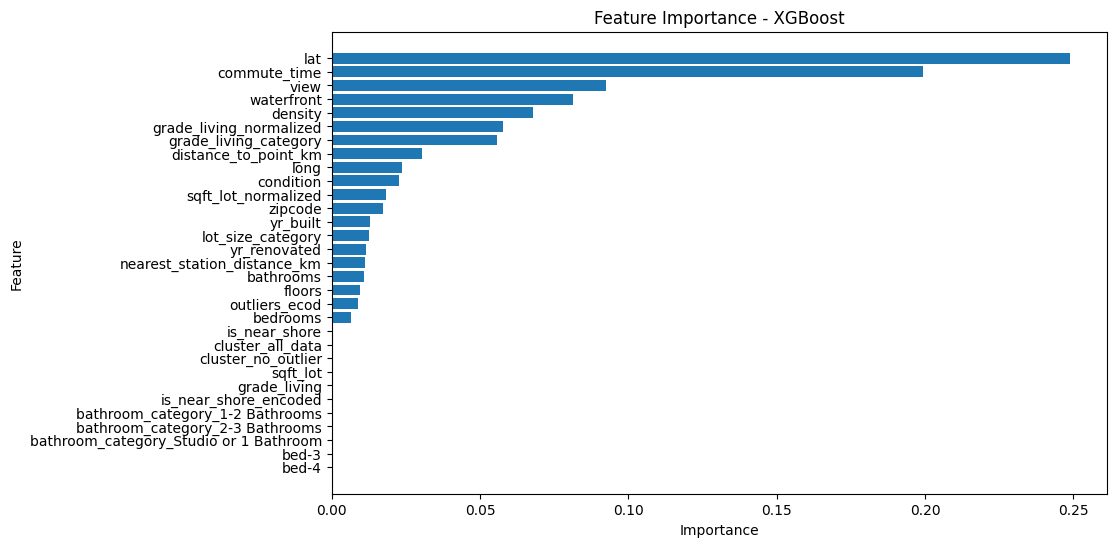

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Data preparation
data_model = data_corr_1.copy()
data_model["bed-3"] = data_model["bedrooms_cat_<3"]
data_model["bed-4"] = data_model["bedrooms_cat_>4"]
data_model = data_model.drop(["bedrooms_cat_<3", "bedrooms_cat_>4", 'bedrooms_cat', 'bathroom_category'], axis=1)

# Splitting data into features and target variable
X = data_model.drop('price', axis=1)
y = data_model['price']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model Training
xgb_model = XGBRegressor(n_estimators=200, max_depth=5)
xgb_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Model - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Feature importance
importance = xgb_model.feature_importances_
features = X.columns

# Creating a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()


In [44]:
import itertools
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

# Make sure to use data_corr_1 consistently
features = data_corr_1.drop(['price', 'outliers_ecod', 'cluster_all_data', 'cluster_no_outlier'], axis=1)
features["bed-3"] = features["bedrooms_cat_<3"]
features["bed-4"] = features["bedrooms_cat_>4"]
features = features.drop(["bedrooms_cat_<3", "bedrooms_cat_>4", 'bedrooms_cat', 'bathroom_category'], axis=1)
target = data_corr_1['price']

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'MAE': mae, 'R2': r2}

# Check and print columns
print("Available columns in the DataFrame:", features.columns.tolist())

# Generate combinations of features
feature_combinations = list(itertools.combinations(features.columns, 2))

for combination in feature_combinations:
    selected_features = list(combination)
    
    # Ensure the selected features exist in the DataFrame
    try:
        X_train, X_test, y_train, y_test = train_test_split(data_corr_1.loc[:, selected_features], target, test_size=0.2, random_state=42)
    except KeyError as e:
        print(f"KeyError: {e}")
        print(f"Combination causing error: {selected_features}")
        continue  # Skip this iteration if there's an error

    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    combination_results = {'features': selected_features}

    grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
    grid_search_xgb.fit(X_train, y_train)
    best_xgb = grid_search_xgb.best_estimator_
    y_pred = best_xgb.predict(X_test)
    combination_results['XGBoost Best Params'] = grid_search_xgb.best_params_

    evaluation = evaluate_model(y_test, y_pred)
    combination_results['XGBoost'] = evaluation

    results.append(combination_results)

# Flatten the results for easier analysis
flattened_results = []
for result in results:
    features = result['features']
    xgb_params = result.get('XGBoost Best Params', None)
    for model_name, metrics in result.items():
        if model_name not in ['features', 'XGBoost Best Params']:
            flattened_results.append({
                'features': features,
                'model': model_name,
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'XGB Params': xgb_params
            })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(flattened_results)

# Display the results
print(results_df)


Available columns in the DataFrame: ['bedrooms', 'bathrooms', 'sqft_lot_normalized', 'floors', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'nearest_station_distance_km', 'density', 'commute_time', 'distance_to_point_km', 'is_near_shore', 'grade_living_normalized', 'lot_size_category', 'grade_living_category', 'sqft_lot', 'grade_living', 'is_near_shore_encoded', 'bathroom_category_1-2 Bathrooms', 'bathroom_category_2-3 Bathrooms', 'bathroom_category_Studio or 1 Bathroom', 'bed-3', 'bed-4']
KeyError: "['bed-3'] not in index"
Combination causing error: ['bedrooms', 'bed-3']
KeyError: "['bed-4'] not in index"
Combination causing error: ['bedrooms', 'bed-4']
KeyError: "['bed-3'] not in index"
Combination causing error: ['bathrooms', 'bed-3']
KeyError: "['bed-4'] not in index"
Combination causing error: ['bathrooms', 'bed-4']
KeyError: "['bed-3'] not in index"
Combination causing error: ['sqft_lot_normalized', 'bed-3']
KeyError: "['bed-4'] not in 

In [ ]:
results_df.sort_values(by=['MSE']).iloc[200]

,features,model,MSE,MAE,R2,XGB Params
200,"[zipcode, grade_living]",XGBoost,7.320262e+09,61983.607576,0.700892,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
196,"[zipcode, grade_living_normalized]",XGBoost,7.320262e+09,61983.607576,0.700892,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
254,"[density, grade_living]",XGBoost,7.339476e+09,62136.068941,0.700107,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
250,"[density, grade_living_normalized]",XGBoost,7.339476e+09,62136.068941,0.700107,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
198,"[zipcode, grade_living_category]",XGBoost,7.732214e+09,63486.410484,0.684059,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
...,...,...,...,...,...,...
186,"[yr_renovated, bathroom_category_1-2 Bathrooms]",XGBoost,2.443345e+10,120235.954556,0.001642,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
188,"[yr_renovated, bathroom_category_Studio or 1 B...",XGBoost,2.443345e+10,120235.954556,0.001642,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
323,"[bathroom_category_1-2 Bathrooms, bathroom_cat...",XGBoost,2.447518e+10,120292.657999,-0.000064,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
322,"[bathroom_category_1-2 Bathrooms, bathroom_cat...",XGBoost,2.447518e+10,120292.657999,-0.000064,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."


In [55]:
import itertools
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

# Make sure to use data_corr_1 consistently
features = data_corr_1.drop(['price', 'outliers_ecod', 'cluster_all_data', 'cluster_no_outlier'], axis=1)
features["bed-3"] = features["bedrooms_cat_<3"]
features["bed-4"] = features["bedrooms_cat_>4"]
features = features.drop(["bedrooms_cat_<3", "bedrooms_cat_>4", 'bedrooms_cat', 'bathroom_category'], axis=1)
target = data_corr_1['price']

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'MAE': mae, 'R2': r2}

# Check and print columns
print("Available columns in the DataFrame:", features.columns.tolist())

# Generate combinations of features
feature_combinations = list(itertools.combinations(features.columns, 3))

for combination in feature_combinations:
    selected_features = list(combination)
    
    # Ensure the selected features exist in the DataFrame
    try:
        X_train, X_test, y_train, y_test = train_test_split(data_corr_1.loc[:, selected_features], target, test_size=0.2, random_state=42)
    except KeyError as e:
        print(f"KeyError: {e}")
        print(f"Combination causing error: {selected_features}")
        continue  # Skip this iteration if there's an error

    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    combination_results = {'features': selected_features}

    grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
    grid_search_xgb.fit(X_train, y_train)
    best_xgb = grid_search_xgb.best_estimator_
    y_pred = best_xgb.predict(X_test)
    combination_results['XGBoost Best Params'] = grid_search_xgb.best_params_

    evaluation = evaluate_model(y_test, y_pred)
    combination_results['XGBoost'] = evaluation

    results.append(combination_results)

# Flatten the results for easier analysis
flattened_results = []
for result in results:
    features = result['features']
    xgb_params = result.get('XGBoost Best Params', None)
    for model_name, metrics in result.items():
        if model_name not in ['features', 'XGBoost Best Params']:
            flattened_results.append({
                'features': features,
                'model': model_name,
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'XGB Params': xgb_params
            })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(flattened_results)

# Display the results
print(results_df)


Available columns in the DataFrame: ['bedrooms', 'bathrooms', 'sqft_lot_normalized', 'floors', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'nearest_station_distance_km', 'density', 'commute_time', 'distance_to_point_km', 'is_near_shore', 'grade_living_normalized', 'lot_size_category', 'grade_living_category', 'sqft_lot', 'grade_living', 'is_near_shore_encoded', 'bathroom_category_1-2 Bathrooms', 'bathroom_category_2-3 Bathrooms', 'bathroom_category_Studio or 1 Bathroom', 'bed-3', 'bed-4']
KeyError: "['bed-3'] not in index"
Combination causing error: ['bedrooms', 'bathrooms', 'bed-3']
KeyError: "['bed-4'] not in index"
Combination causing error: ['bedrooms', 'bathrooms', 'bed-4']
KeyError: "['bed-3'] not in index"
Combination causing error: ['bedrooms', 'sqft_lot_normalized', 'bed-3']
KeyError: "['bed-4'] not in index"
Combination causing error: ['bedrooms', 'sqft_lot_normalized', 'bed-4']
KeyError: "['bed-3'] not in index"
Combination causin

KeyboardInterrupt: 

In [61]:
results_df.sort_values(by='MSE').iloc[0:10]

,features,model,MSE,MAE,R2,XGB Params
200,"[zipcode, grade_living]",XGBoost,7.320262e+09,61983.607576,0.700892,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
196,"[zipcode, grade_living_normalized]",XGBoost,7.320262e+09,61983.607576,0.700892,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
254,"[density, grade_living]",XGBoost,7.339476e+09,62136.068941,0.700107,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
250,"[density, grade_living_normalized]",XGBoost,7.339476e+09,62136.068941,0.700107,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
198,"[zipcode, grade_living_category]",XGBoost,7.732214e+09,63486.410484,0.684059,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
252,"[density, grade_living_category]",XGBoost,7.792693e+09,63841.629691,0.681588,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
211,"[lat, grade_living_normalized]",XGBoost,8.064255e+09,64164.609733,0.670492,"{'colsample_bytree': 1.0, 'learning_rate': 0.1..."
215,"[lat, grade_living]",XGBoost,8.064255e+09,64164.609733,0.670492,"{'colsample_bytree': 1.0, 'learning_rate': 0.1..."
205,"[lat, long]",XGBoost,8.501344e+09,64675.420821,0.652632,"{'colsample_bytree': 1.0, 'learning_rate': 0.1..."
261,"[commute_time, grade_living_normalized]",XGBoost,8.624193e+09,69167.783158,0.647613,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."


In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle


data = pd.read_csv("../../clustered_data_v2.csv")



one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
label_encoder = LabelEncoder()


one_hot_encoded_columns = pd.DataFrame(one_hot_encoder.fit_transform(data[['bathroom_category', 'bedrooms_cat']]),
                                       columns=one_hot_encoder.get_feature_names_out(['bathroom_category', 'bedrooms_cat']))

data['is_near_shore_encoded'] = label_encoder.fit_transform(data['is_near_shore'])


data_encoded = pd.concat([data.drop(['bathroom_category', 'bedrooms_cat', 'is_near_shore'], axis=1), one_hot_encoded_columns], axis=1)

data_corr_1 = data_encoded[data_encoded["cluster_all_data"] == 1]

constant_columns = [col for col in data_corr_1.columns if data_corr_1[col].nunique() == 1]

data_reduced_corr_1 = data_corr_1.drop(columns=constant_columns)

data_model = data_reduced_corr_1[['price', 'grade_living_normalized', 'lat', 'commute_time', 'distance_to_point_km', 'nearest_station_distance_km']]

# data_model["bed-3"] = data_reduced_corr_1["bedrooms_cat_<3"]
# data_model["bed-4"] = data_reduced_corr_1["bedrooms_cat_>4"]

# Bağımsız değişkenler ve bağımlı değişkenin ayrılması
X = data_model.drop('price', axis=1)  # Bağımsız değişkenlerin listesini güncelleyin
y = data_model['price']  # Bağımlı değişkenin adını güncelleyin

# Verilerin eğitim ve test kümelerine bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veri önişleme: Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def eval_function(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


# XGBoost Model Hyperparameter Tuning
xgb_model = XGBRegressor()
xgb_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
xgb_pred_tuned = xgb_best_model.predict(X_test)
xgb_scores_tuned = eval_function(y_test, xgb_pred_tuned)

with open('xgb_best_model.pkl', 'wb') as file:
    pickle.dump(xgb_best_model, file)

# Scaler'ın kaydedilmesi
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


print("XGBoost Modeli (Tuned) - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(*xgb_scores_tuned))


XGBoost Modeli (Tuned) - MSE: 5666648319.2107, RMSE: 75277.1434, MAE: 55019.0028, R2: 0.7685
